<a href="https://colab.research.google.com/github/AhmedSSoliman/English_to_Dutch_MarianMT_Transformers/blob/main/English_to_Dutch_MarianMT_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers[sentencepiece]
!pip install -q datasets
!pip install -q sacrebleu
!pip install -q tqdm

Found existing installation: tqdm 4.43.0
Uninstalling tqdm-4.43.0:
  Successfully uninstalled tqdm-4.43.0
     |████████████████████████████████| 76 kB 2.2 MB/s 


In [ ]:
!gdown https://drive.google.com/uc?id=18NmpZ8BWWMEWlmSCacLDOKcGaz-qHoOg

Downloading...
From: https://drive.google.com/uc?id=18NmpZ8BWWMEWlmSCacLDOKcGaz-qHoOg
To: /content/Dutch.xlsx
14.3MB [00:00, 125MB/s]


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from datasets import Dataset,load_metric
from sklearn.model_selection import train_test_split
import torch
from tqdm.auto import tqdm
from transformers import MarianConfig,MarianMTModel,MarianTokenizer,DataCollatorForSeq2Seq,AdamW
checkpoint = 'Helsinki-NLP/opus-mt-en-nl'

In [ ]:
df = pd.read_excel('/content/Dutch.xlsx')
df.head()

,English,Dutch
0,Resumption of the session,Hervatting van de zitting
1,I declare resumed the session of the European ...,Ik verklaar de zitting van het Europees Parlem...
2,"Although, as you will have seen, the dreaded '...","Zoals u heeft kunnen constateren, is de grote ..."
3,You have requested a debate on this subject in...,U heeft aangegeven dat u deze vergaderperiode ...
4,"In the meantime, I should like to observe a mi...",Nu wil ik graag op verzoek van een aantal coll...


In [ ]:
df.isnull().sum()

English    1393
Dutch       121
dtype: int64

In [ ]:
df.dropna(axis = 0,inplace=True)
df.reset_index(inplace=True)
df.drop('index',axis = 1,inplace=True)

In [ ]:
df.head()

,English,Dutch
0,Resumption of the session,Hervatting van de zitting
1,I declare resumed the session of the European ...,Ik verklaar de zitting van het Europees Parlem...
2,"Although, as you will have seen, the dreaded '...","Zoals u heeft kunnen constateren, is de grote ..."
3,You have requested a debate on this subject in...,U heeft aangegeven dat u deze vergaderperiode ...
4,"In the meantime, I should like to observe a mi...",Nu wil ik graag op verzoek van een aantal coll...


In [ ]:
train_df,val_df = train_test_split(df,random_state = 42,test_size = 0.2)

In [ ]:
print(train_df.shape)
print(val_df.shape)

(78788, 2)
(19698, 2)


In [ ]:
#Hyperparameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
max_length = 512
batch_size = 8
learning_rate = 1e-5

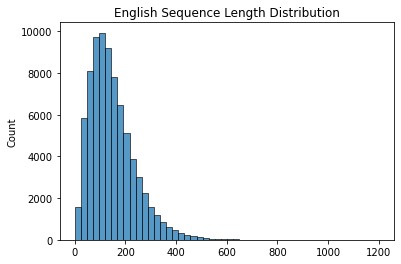

In [ ]:
length_list = []
for i in train_df.English:
  length_list.append(len(i))
sns.histplot(length_list,bins = 50)
plt.title('English Sequence Length Distribution')
plt.show()

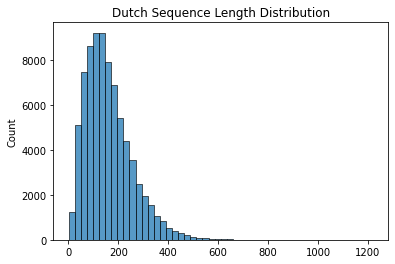

In [ ]:
length_list = []
for i in train_df.Dutch:
  length_list.append(len(i))
sns.histplot(length_list,bins = 50)
plt.title('Dutch Sequence Length Distribution')
plt.show()

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['English', 'Dutch'],
    num_rows: 78788
})
Dataset({
    features: ['English', 'Dutch'],
    num_rows: 19698
})


In [ ]:
tokenizer = MarianTokenizer.from_pretrained(checkpoint)
tokenizer

PreTrainedTokenizer(name_or_path='Helsinki-NLP/opus-mt-en-nl', vocab_size=67028, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

In [ ]:
model = MarianMTModel.from_pretrained(checkpoint)
model.config.pad_token_id

67027

In [ ]:
def preprocess(examples,MAX_LENGTH = 512):
  model_inputs = tokenizer(examples['English'],
                           max_length=MAX_LENGTH,
                           padding = 'max_length',
                           truncation=True,
                           return_attention_mask = True)
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(examples['Dutch'],
                        max_length=MAX_LENGTH,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True)
  model_inputs['labels'] = targets['input_ids']
  model_inputs['decoder_input_ids'] = targets['input_ids']
  model_inputs['decoder_attention_mask'] = targets['attention_mask']
  return model_inputs

In [ ]:
train_inputs = train_dataset.map(preprocess,batched = True)
val_inputs = val_dataset.map(preprocess,batched = True)
train_inputs = train_inputs.remove_columns(['English','Dutch'])
val_inputs = val_inputs.remove_columns(['English','Dutch'])

  0%|          | 0/79 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                       max_length=512,
                                       model = model)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_inputs,
                                               batch_size = batch_size,
                                               shuffle = True,
                                               collate_fn = data_collator)
val_dataloader = torch.utils.data.DataLoader(val_inputs,
                                             batch_size = batch_size,
                                             shuffle = False,
                                             collate_fn = data_collator)

In [ ]:
for batch in train_dataloader:
  break
batch['labels'][batch['labels']==67027] = -100
print(batch['labels'])

tensor([[17486,  1193,   275,  ...,  -100,  -100,  -100],
        [ 1532,     5,   853,  ...,  -100,  -100,  -100],
        [   49, 27922,     6,  ...,  -100,  -100,  -100],
        ...,
        [ 1532,  1700, 41085,  ...,  -100,  -100,  -100],
        [17486,   141,  4156,  ...,  -100,  -100,  -100],
        [  596,    42,  3751,  ...,  -100,  -100,  -100]])


In [ ]:
# model.to(device)
# outputs = model(**batch)
# print(outputs.logits.shape)
# print(outputs.loss)
# output = torch.argmax(outputs.logits,dim =-1)
# tokenizer.batch_decode(output)

In [ ]:
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
print(num_training_steps)

19698


In [ ]:
optimizer = AdamW(model.parameters(),lr = learning_rate)

In [ ]:
model.to(device)
progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs):
  epoch_loss = 0.0
  run_loss = 0.0
  for batch in train_dataloader:
    batch['labels'][batch['labels']==67027] = -100
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    run_loss += loss 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  epoch_loss = run_loss/len(train_dataloader)
  print(100*'-')
  print('Epoch:{}====>Loss:{:.4f}'.format(epoch+1,epoch_loss))

 50%|█████     | 9849/19698 [1:17:11<1:06:21,  2.47it/s]

----------------------------------------------------------------------------------------------------
Epoch:1====>Loss:1.6144


100%|██████████| 19698/19698 [2:34:35<00:00,  2.48it/s]

----------------------------------------------------------------------------------------------------
Epoch:2====>Loss:1.5116


In [ ]:
model.save_pretrained('MarianMT-Englidh-to-dutch')

Configuration saved in MarianMT-Englidh-to-dutch/config.json
Model weights saved in MarianMT-Englidh-to-dutch/pytorch_model.bin


In [ ]:
tokenizer.save_pretrained('MarianMT-Englidh-to-dutch')

tokenizer config file saved in MarianMT-Englidh-to-dutch/tokenizer_config.json
Special tokens file saved in MarianMT-Englidh-to-dutch/special_tokens_map.json


('MarianMT-Englidh-to-dutch/tokenizer_config.json',
 'MarianMT-Englidh-to-dutch/special_tokens_map.json',
 PosixPath('MarianMT-Englidh-to-dutch/source_spm'),
 PosixPath('MarianMT-Englidh-to-dutch/target_spm'),
 PosixPath('MarianMT-Englidh-to-dutch/vocab'),
 PosixPath('MarianMT-Englidh-to-dutch/tokenizer_config_file'),
 'MarianMT-Englidh-to-dutch/added_tokens.json')